### 1. Imports

In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import gym
import numpy as np
from stable_baselines3 import PPO
from matplotlib import pyplot as plt

In [2]:
# Import classes
from rl_environment import Environment

### 2. Environment creation

#### Parameters for Simulation

In [3]:
number_of_regional_warehouses = 1
max_inventory_amount_regional_warehouses = 30
max_inventory_amount_central_warehouse = 60
customer_demand_per_step = [1,2]  # List needs one entry per regional warehouse 
simulation_length = 50
lead_time = 2
shipment_amount = [5, 10]  # Regarding regional warehouses
with_manufacturer = False
cw_shipment_amount = 10  # Regarding central warehosue
manufacturer_prod_capacity_per_step = 5
max_min_price_per_unit = [5, 0.1]
price_multiplier = 0.05
shipment_fixed_cost = 0.5  # Reward penalty

#### Parameters for Agent Training

In [4]:
algorithm = "PPO"
training_steps = 50000

print("-> Equals to " + str(int(training_steps/simulation_length)) + " simulation training rounds")

-> Equals to 1000 simulation training rounds


#### Creating Environment

In [5]:
env = Environment(number_of_regional_wh = number_of_regional_warehouses, 
                  rw_inventory_limit = max_inventory_amount_regional_warehouses, 
                  cw_inventory_limit = max_inventory_amount_central_warehouse,
                  demand = customer_demand_per_step,
                  sim_length = simulation_length,
                  lead_time = lead_time,
                  shipment_amount = shipment_amount,
                  manufacturer = with_manufacturer,
                  cw_shipment_amount = cw_shipment_amount,
                  mf_prod_capacity = manufacturer_prod_capacity_per_step,
                  max_min_price_per_unit = max_min_price_per_unit,
                  price_multiplier = price_multiplier
                 )

env.print_environment_information()

Simulation created with the following parameters:
________________________________________________________________________________
Simulation | Round 1
-------------------
-> Active shipments:
No active shipments

-> Warehouses:
central_warehouse ; Inventory: 20
regional_warehouse_1 ; ID: 1 ; Inventory: 10 ; Demand: 1 ; Lost sales: 0
________________________________________________________________________________
Environment Information
-----------------------
Observation space: Dict(rw_inventories:MultiDiscrete([31]), shipments:MultiDiscrete([2]))
Action space: MultiDiscrete([3])
Starting state: {'rw_inventories': array([10]), 'shipments': array([0])}
Reward penalty per unit shipped:
Max = 0.25
Min = 0.01
________________________________________________________________________________


### 3. RL model training

###### Model 1: PPO
Proximal Policy Optimization
https://openai.com/blog/openai-baselines-ppo/

In [6]:
ppo_model = PPO("MultiInputPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=training_steps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05

lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost:

lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.0

lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05

lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.0

lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05

lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -5.91       |
| time/                   |             |
|    fps         

lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0

lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.

lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.0

lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | -0.455      |
| time/                   |             |
|    fps                  | 673         |
|    iterations           | 8           |
|    time_elapsed         | 24          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.0

lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 2.84        |
| time/                   |   

lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lo

lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 9.59        |
| time/                   |             |
|    fps                  | 648         |
|    iterations           | 15          |
|    time_elapsed         | 47          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.001978809 |
|    clip_fraction        | 0.0231      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.179      |
|    explained_variance   | 0.0419      |
|    learning_rate        | 0.0003      |
|    loss                 | 1.54        

lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost

lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lo

lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.705
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
lost: 0.05
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 50           |
|    ep_rew_mean          | 12.9         |
| time/                   |              |
|    fps                  | 644          |
|    iterations           | 23           |
|    time_elapsed         | 73           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0019929674 |
|    clip_fraction        | 0.0176       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.113       |
|    explained_variance   | 0.0157       |
|    learning_rate        | 0.0

###### Learning Curve

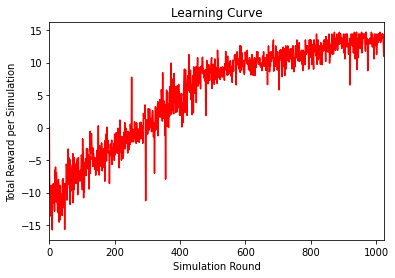

In [7]:
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot(env.total_reward, color="red")
plt.title("Learning Curve")
plt.xlim(0, len(env.total_reward))
plt.ylabel("Total Reward per Simulation")
plt.xlabel("Simulation Round")
plt.show()

### 4. Run simulation

In [8]:
# Reset environment for simulation
state = env.reset()
done = False

# Graph data
inventory_levels = {}
for rw_id in env.simulation.get_regional_warehouses():
    inventory_levels[rw_id] = []
    
cw_inventory_level = []

# Run simulation with model
while not done:
    action, _states = ppo_model.predict(state)
    state, reward, done, info = env.step(action)
    
    # For Graph
    i = 1
    for inv in info["RW Invs:"]:
        inventory_levels[i].append(inv)
        i += 1
    try:
        cw_inventory_level.append(info["CW Inv:"])
    except:
        pass
    
    # print(env.simulation.print_state())
    for i in info:
        print(i, info[i], end=" | ")
    print()
    
print("\n", env.evaluation_parameters())

Steps left: 49 | RW Invs: [9] | Shipments [0] | Action: [0] | Reward: 0.1 | 
Steps left: 48 | RW Invs: [8] | Shipments [0] | Action: [0] | Reward: 0.11 | 
Steps left: 47 | RW Invs: [7] | Shipments [0] | Action: [0] | Reward: 0.12 | 
Steps left: 46 | RW Invs: [6] | Shipments [0] | Action: [0] | Reward: 0.14 | 
Steps left: 45 | RW Invs: [5] | Shipments [0] | Action: [0] | Reward: 0.17 | 
Steps left: 44 | RW Invs: [4] | Shipments [0] | Action: [0] | Reward: 0.2 | 
Steps left: 43 | RW Invs: [3] | Shipments [0] | Action: [0] | Reward: 0.25 | 
lost: 0.05
Steps left: 42 | RW Invs: [2] | Shipments [1] | Action: [2] | Reward: 0.28 | 
Steps left: 41 | RW Invs: [1] | Shipments [1] | Action: [0] | Reward: 0.5 | 
Steps left: 40 | RW Invs: [10] | Shipments [0] | Action: [0] | Reward: 0.09 | 
Steps left: 39 | RW Invs: [9] | Shipments [0] | Action: [0] | Reward: 0.1 | 
Steps left: 38 | RW Invs: [8] | Shipments [0] | Action: [0] | Reward: 0.11 | 
Steps left: 37 | RW Invs: [7] | Shipments [0] | Action: 

###### Inventory level graphs

[9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


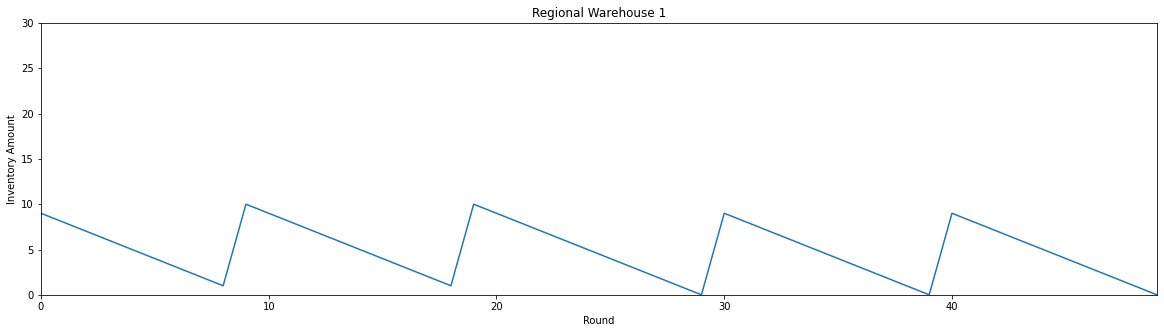

In [11]:
# Plot inventories of regional warehouses

plt.rcParams["figure.figsize"] = (20, 5)

for rw_id in inventory_levels:
    print(inventory_levels[rw_id])
    plt.subplot(1, number_of_regional_warehouses, rw_id)
    plt.plot(inventory_levels[rw_id])
    plt.title("Regional Warehouse " + str(rw_id))
    plt.ylim(0, max_inventory_amount_regional_warehouses)
    plt.xlim(0, simulation_length-1)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")

plt.show()

In [10]:
# Plot central warehouse inventory (Only display if simulated by adding a manufacturer)
if len(cw_inventory_level) != 0:
    plt.rcParams["figure.figsize"] = (20, 5)
    plt.plot(cw_inventory_level, color="green")
    plt.title("Central Warehouse")
    plt.ylim(0, max_inventory_amount_central_warehouse)
    plt.xlim(0, simulation_length-1)
    plt.ylabel("Inventory Amount")
    plt.xlabel("Round")
    plt.show()